# Exploring Missingness

Single cell data is well known for a large amount of dropout resulting in very sparse data sets. While what I have shown so far appears to be very convincing, I am worried about what statistics to use for the X to Autosome question. Here I explore the missingness and illustrate some of the issues we have.

**Summary**
* Missingness replicates marginally and appears to behave worse in specific clusters.
* There does not seem to be a chromosomal affect

In [1]:
import os
import sys
import re
from pathlib import Path
from collections import defaultdict

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.config import memory

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force')
pd.options.display.max_rows = 20

last updated: 2018-09-10 
Git hash: 42b50b2bae7773307f49194899ffbeb2475982b9


In [3]:
raw = nbconfig.seurat.get_raw()

In [4]:
clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters.map(nbconfig.cluster_annot)

reps = raw.columns.str.extract('(?P<rep>rep\d)')
reps.index = raw.columns

meta = reps.join(clusters)

In [5]:
raw_w_meta = pd.concat([raw.T, meta], axis=1)

## Overview

This heatmap shows the genes (y-axis) with >0 reads (white) compared to genes with 0 reads. Here I aggregated reads by summing all cells together for each cell type. We can see that replicate 1 tends to have fewer genes with coverage and that there are blocks of genes that commonly dropout.

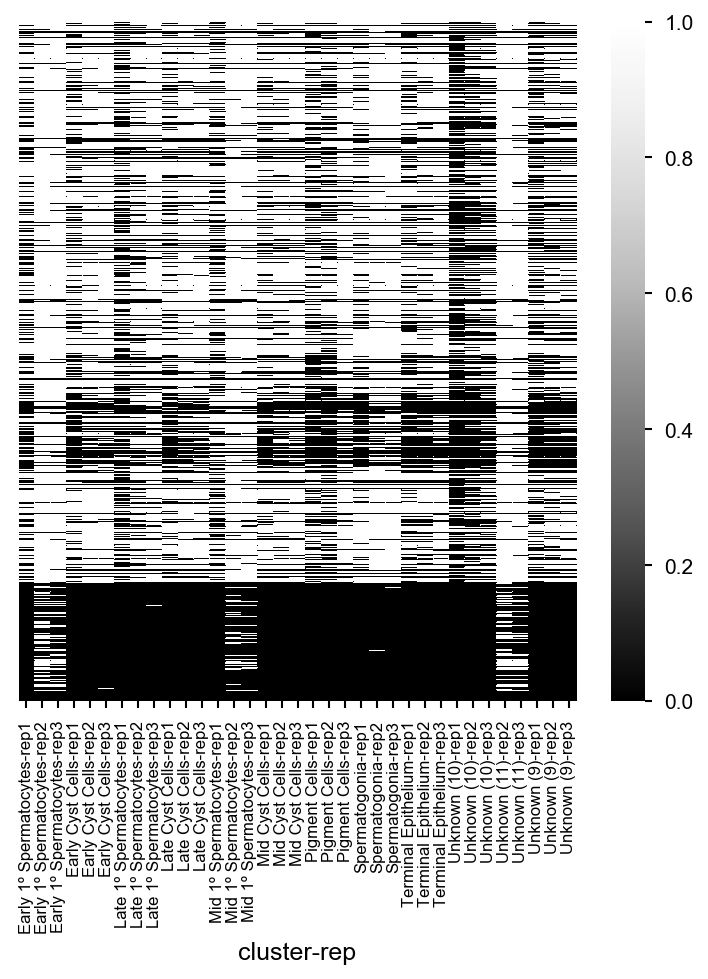

In [6]:
ax = sns.heatmap(raw_w_meta.groupby(['cluster', 'rep']).sum().T > 5, yticklabels=False, xticklabels=True, cmap='Greys_r')
plt.setp(ax.get_xticklabels(), fontsize=8);

## Missingness among replicates

To expand the above view I calculated empirical distributions using sampling. I compared each replicate in a pairwise fashion and iteratively (n=1000) sampled 1 cell from each replicate with replacement. I compared counts of genes that were on (>0 reads) in both replicates (blue line), genes on in only one replicate (orange and green lines). Ideally I would expect to see a peak of blue towards the right and a peak of orange and green overlapping near zero.

Here we see differences among replicates, and these differences seemed to be magnified in different clusters (cell types). For example, the "Mid Cyst Cells" behave roughly as I would expect. However, the "Early 1º Spermatoctyes" show large differences among replicates. This cluster also shows an interesting pattern where the left line (orange) has a very similar pattern to the both (blue) in rep1 vs rep2, while the right line (green) has a similar pattern to both (blue) in rep2 vs rep3. Cell number are a little more even for "Mid Cyst Cells" (rep1=631, rep2=314, rep3=799), while slightly more skewed for "Early 1º Spermatocytes" (rep1=134, rep2=417, rep3=1,056).

These data show that there are differences in dropout among replicates and that these differences interact with cell type. This makes comparisons across cell types to be challenging. 

In [7]:
def sample(cluster, repA, repB, ax):
    _dat1 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repA}"')
    _dat2 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repB}"')

    res = []
    for i in range(1000):
        c1 = _dat1.sample().T.iloc[:, 0] == 0
        c2 = _dat2.sample().T.iloc[:, 0] == 0

        both = (c1 & c2)
        left = c1 > c2
        right = c1 < c2

        res.append([both.sum(), left.sum(), right.sum()])

    pd.DataFrame(res, columns=['both', 'left', 'right']).plot.kde(ax=ax)
    ax.set_title(f'{repA} vs {repB}')

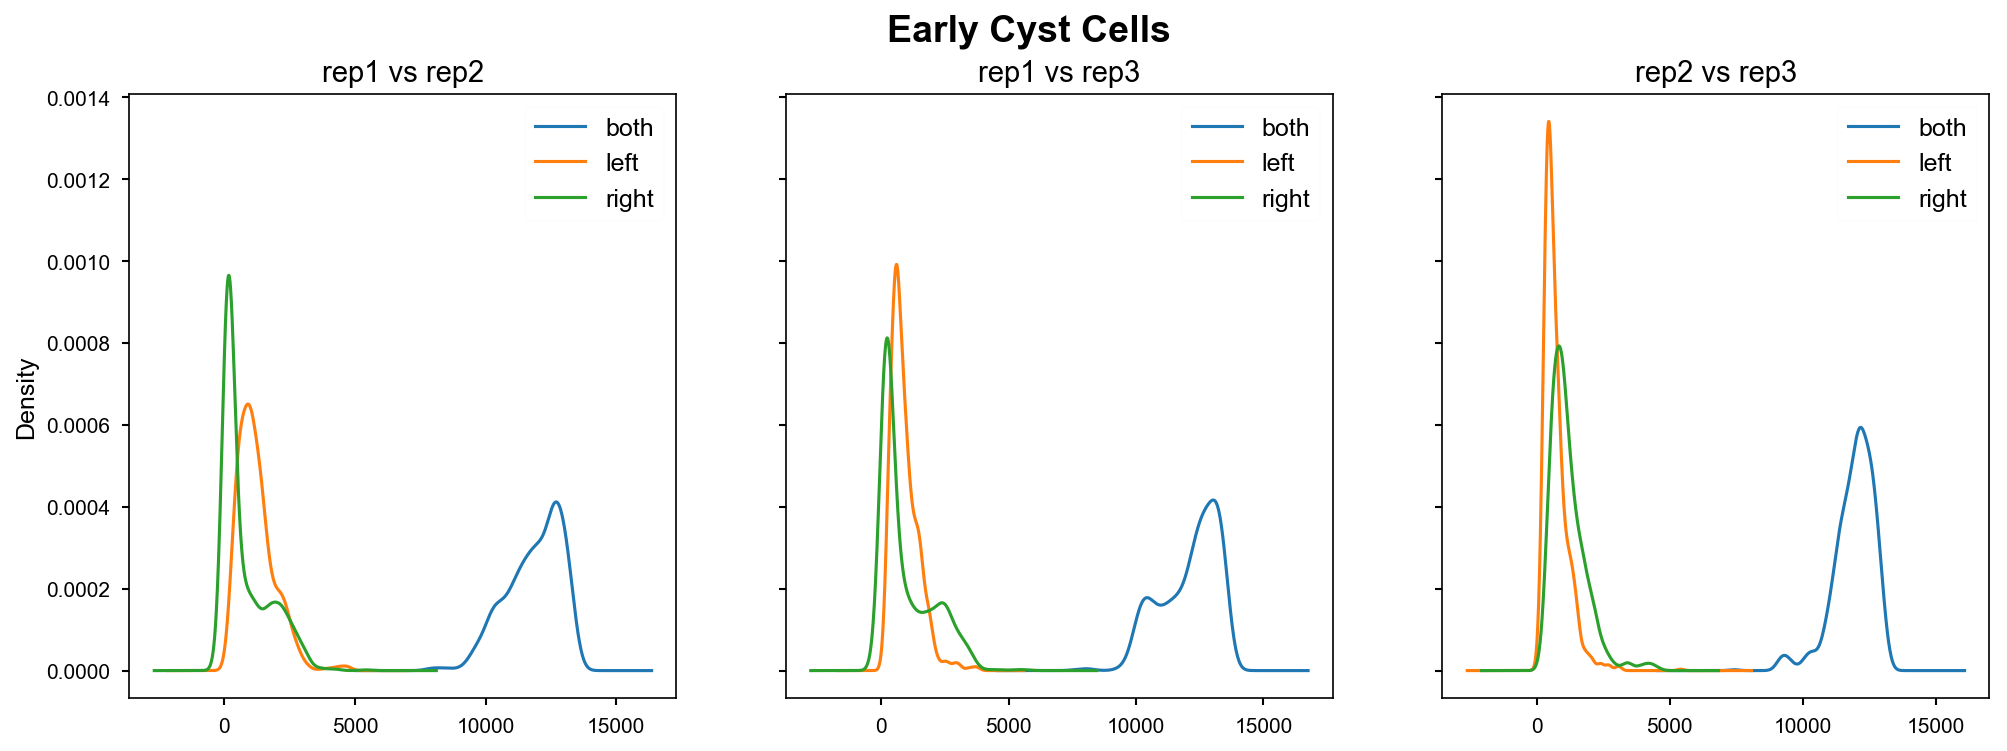

In [8]:
cluster = 'Early Cyst Cells'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

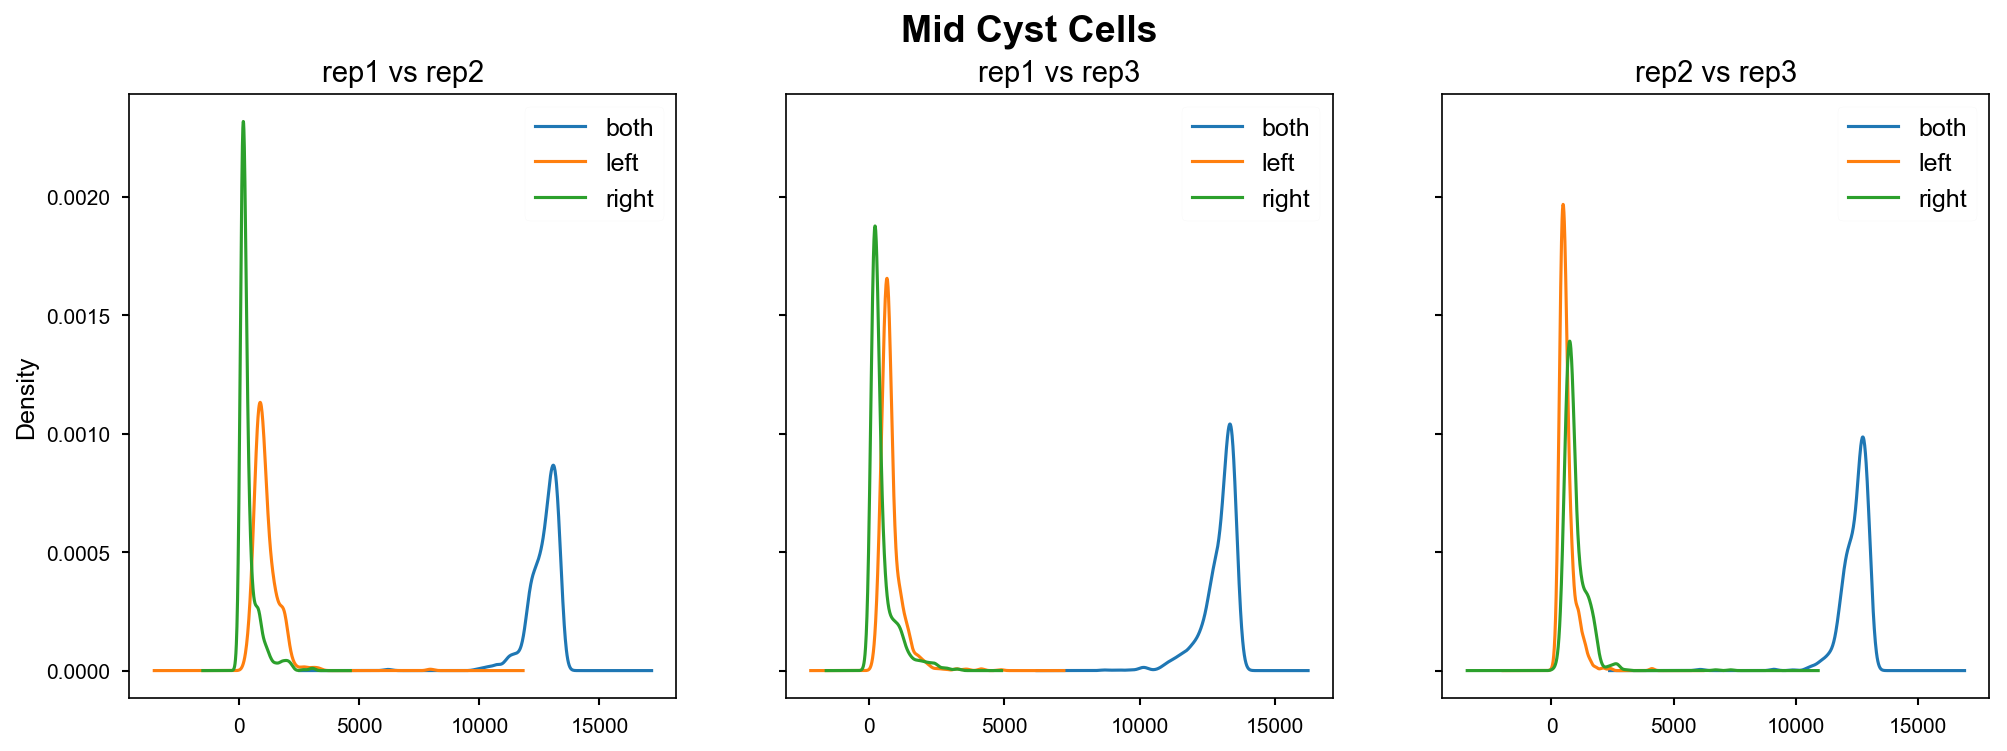

In [9]:
cluster = 'Mid Cyst Cells'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

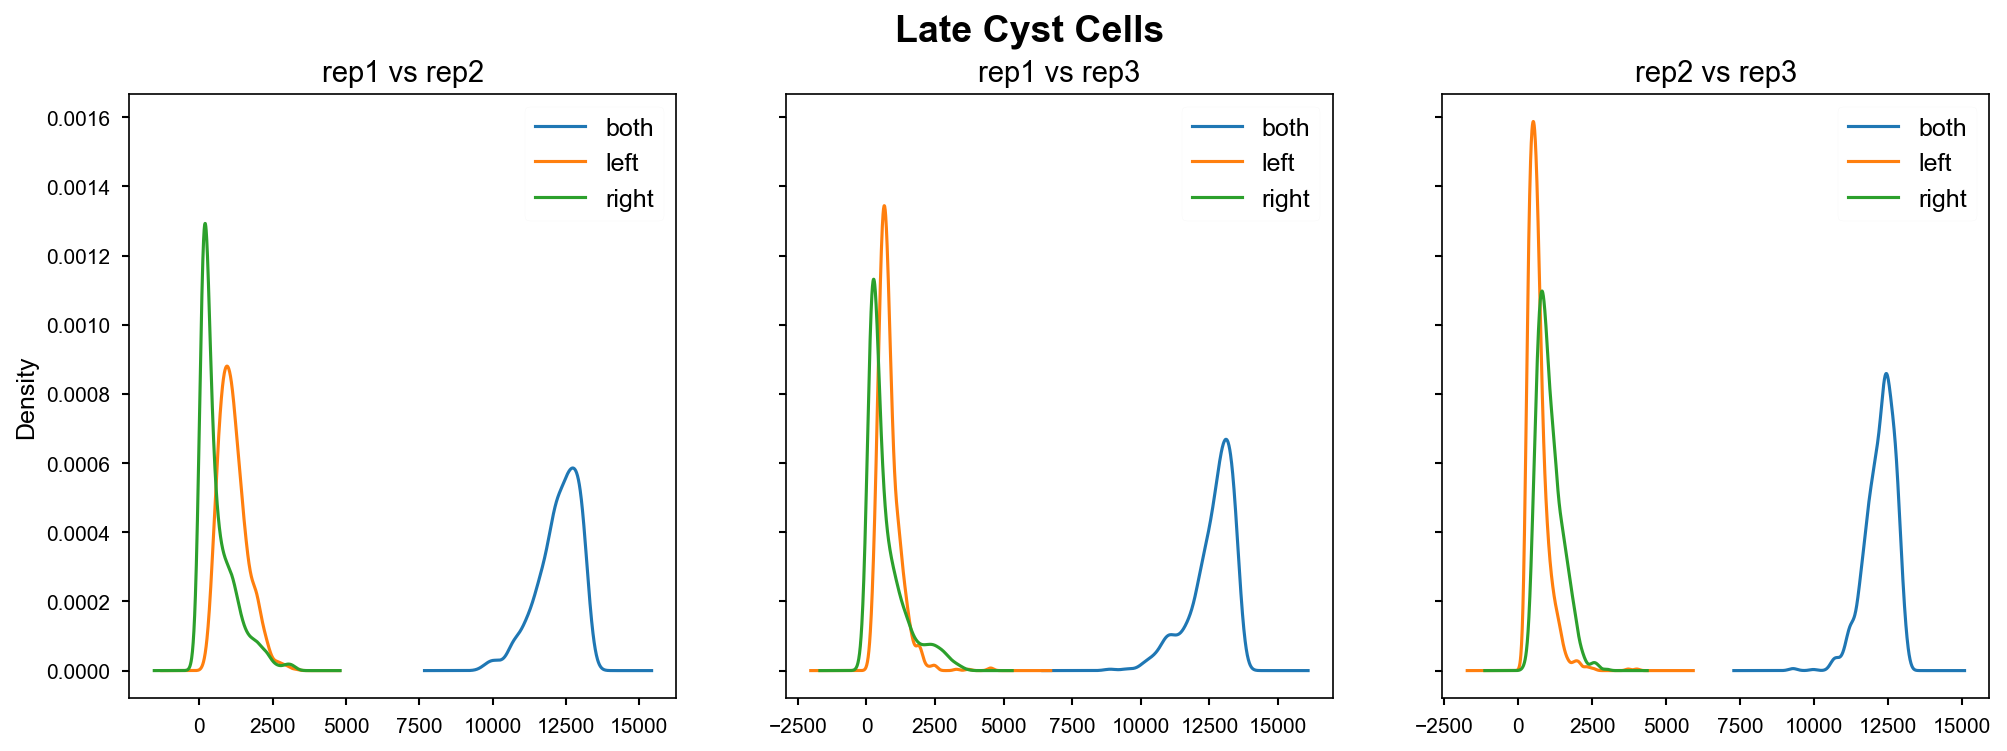

In [10]:
cluster = 'Late Cyst Cells'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

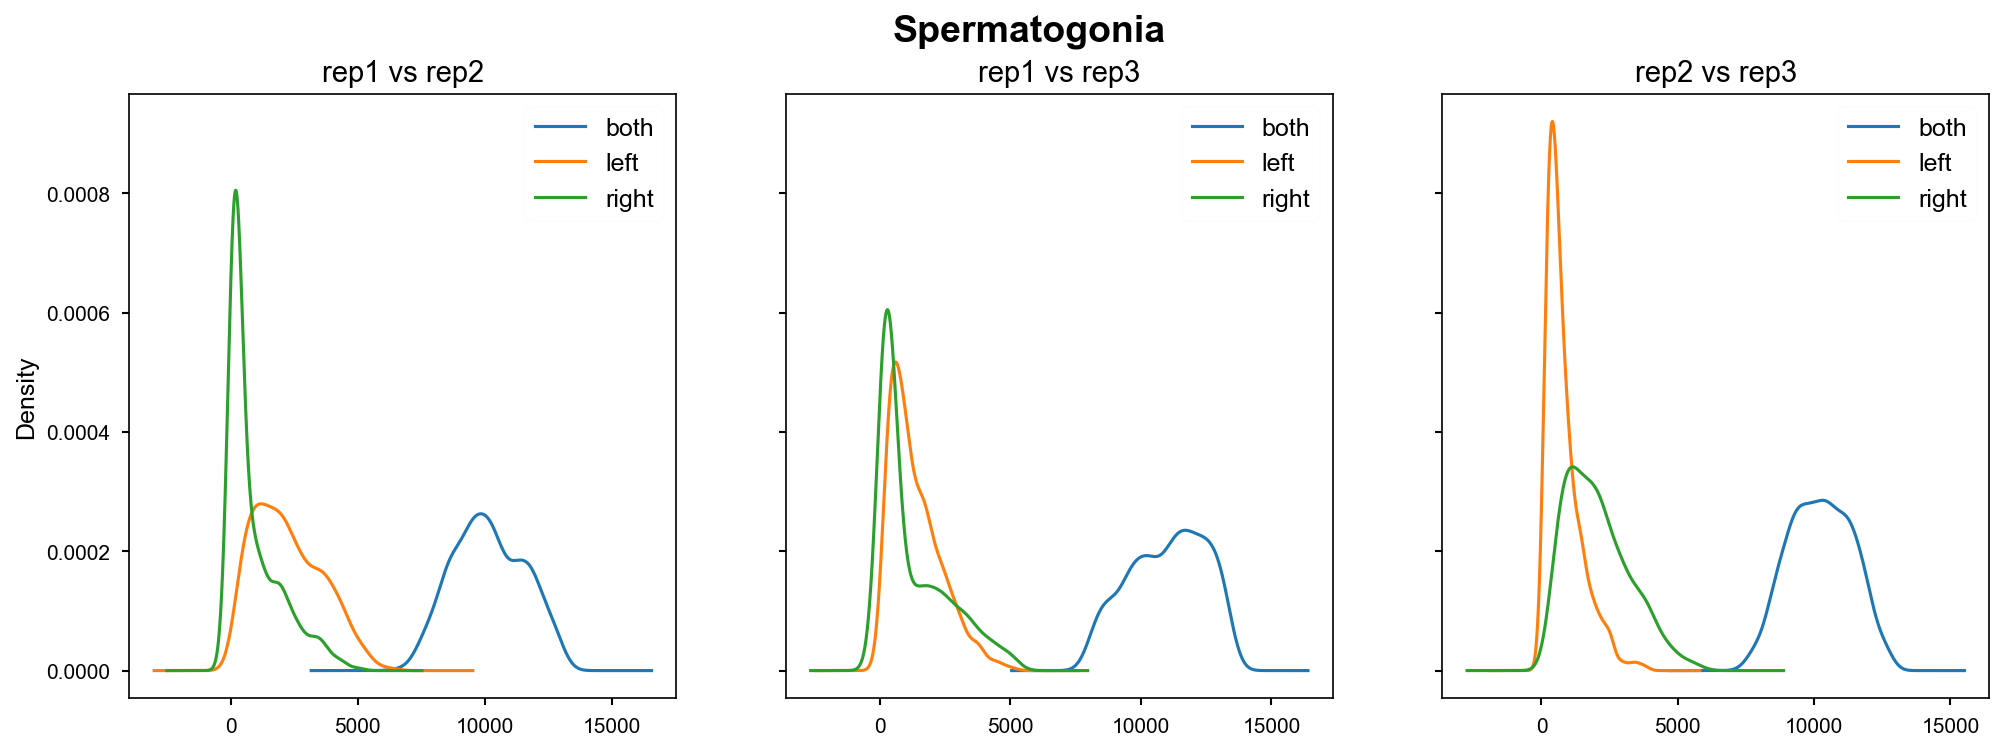

In [11]:
cluster = 'Spermatogonia'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

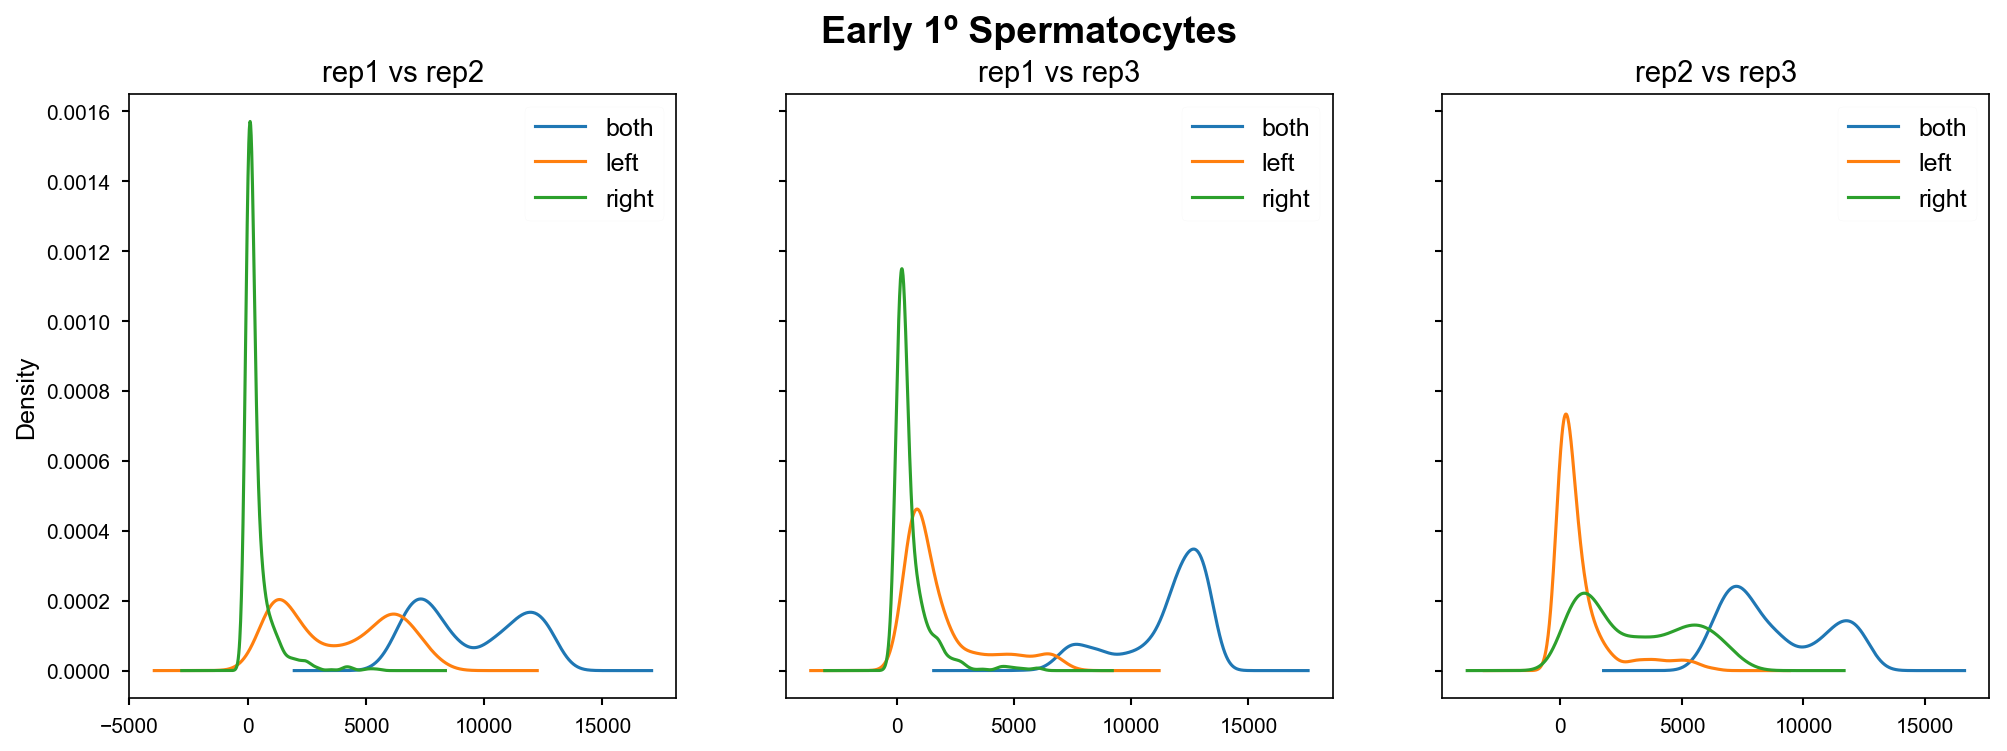

In [12]:
cluster = 'Early 1º Spermatocytes'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

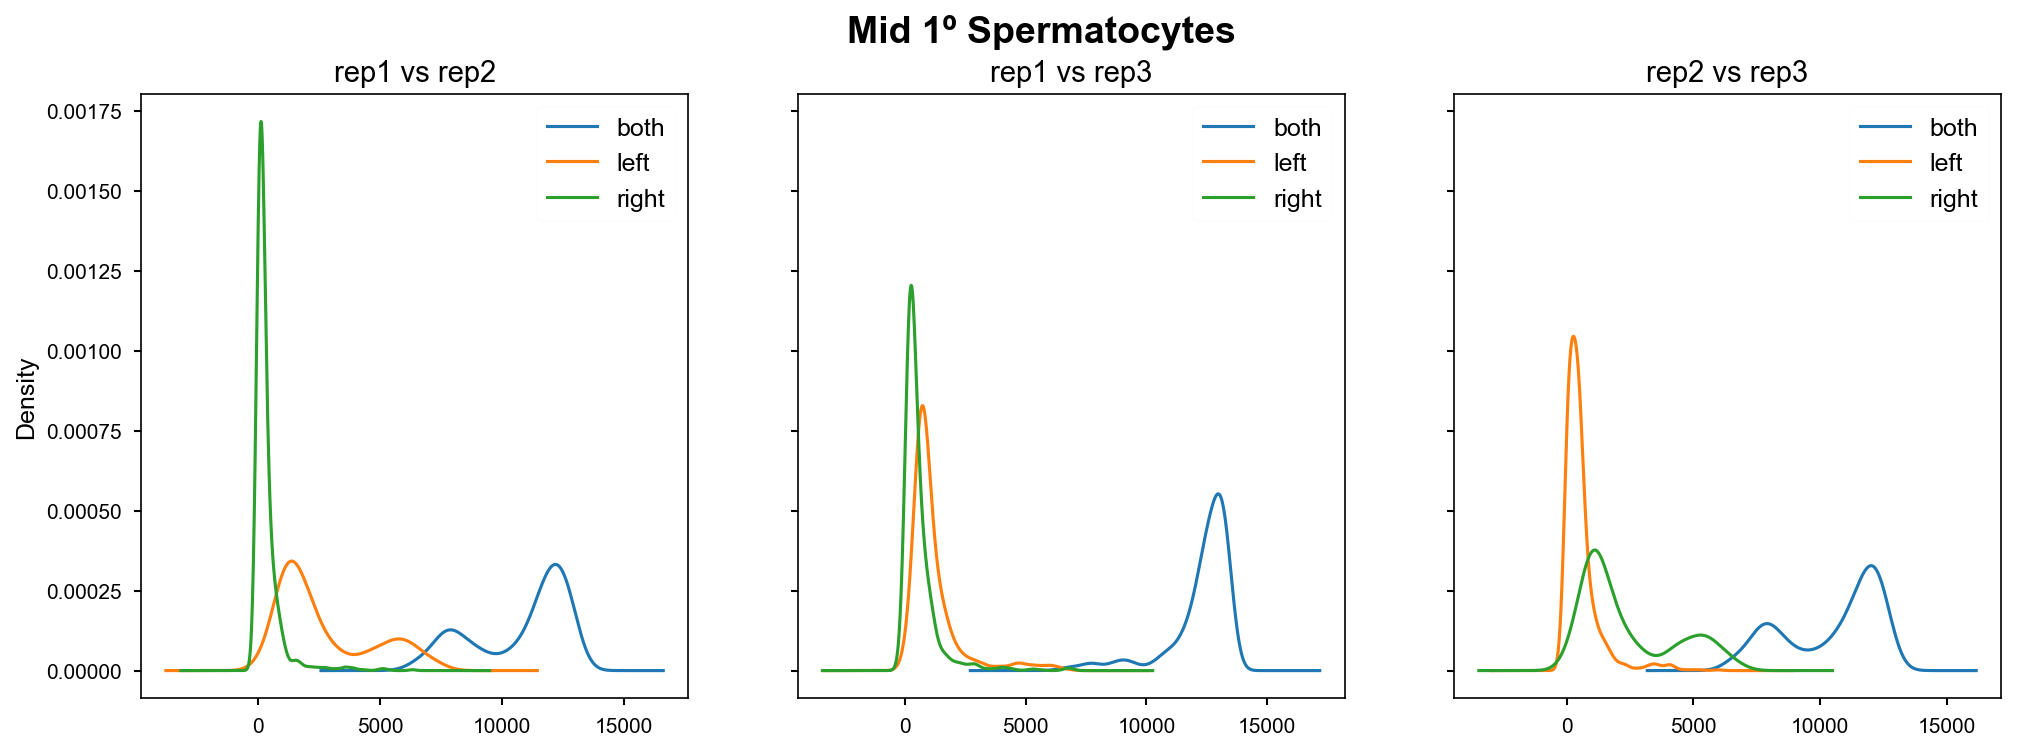

In [13]:
cluster = 'Mid 1º Spermatocytes'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

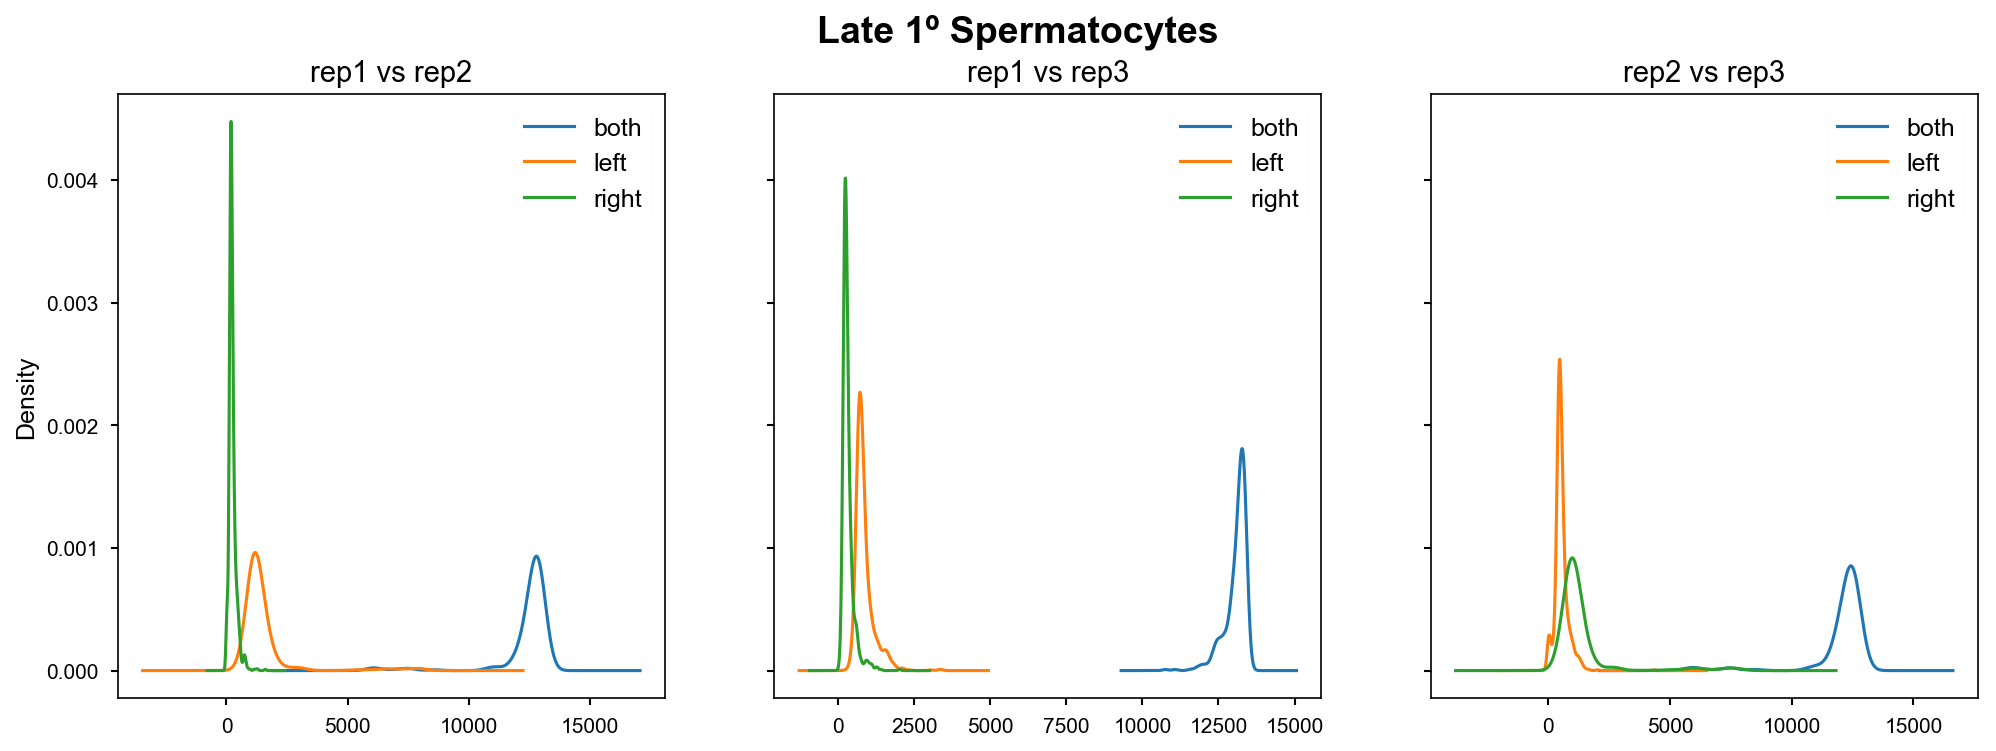

In [14]:
cluster = 'Late 1º Spermatocytes'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
sample(cluster, 'rep1', 'rep2', ax1)
sample(cluster, 'rep1', 'rep3', ax2)
sample(cluster, 'rep2', 'rep3', ax3)
fig.suptitle(cluster);

## Missingness among chromosomes

The main focus on this project is comparing X to autosome expression. Next I wanted to see if missingness was correlated with chromosomal arm. I repeated the sampling scheme as above, except I split counts out by chromosome arm. The distribtion of genes with >0 reads appears to be very similar across chromosome arm, except for the 4th and Y. Note I have set the x-axis to be the same on the plots, the 4th and Y look strange b/c they have few genes compared to the other major arms.

These data show that missingness does not appear to have any bias towards a given chromosomal arm. This would indicate that internal comparisons among chromosomal arms within a cluster is probably better than trying to compare across clusters. 

In [15]:

mapper = {
    'chr2L': 'A',
    'chr2R': 'A',
    'chr3L': 'A',
    'chr3R': 'A',
    'chrX': 'X',
    'chr4': '4',
    'chrY': np.nan,
    'chrM': np.nan,
}

chroms = nbconfig.fbgn2chrom.chrom

In [16]:
def sample2(cluster, repA, repB, axes, title=False):
    _dat1 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repA}"')
    _dat2 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repB}"')

    res = defaultdict(list)
    for i in range(1000):
        c1 = _dat1.sample().T.iloc[:, 0] == 0
        c2 = _dat2.sample().T.iloc[:, 0] == 0

        for c in nbconfig.chrom_order[:7]:
            _genes = chroms.index[chroms == c]
            _c1 = c1.reindex(_genes).dropna()
            _c2 = c2.reindex(_genes).dropna()

            both = (_c1 & _c2)
            left = _c1 > _c2
            right = _c1 < _c2

            res[c].append([both.sum(), left.sum(), right.sum()])

    results = {}
    for k, v in res.items():
        results[k] = pd.DataFrame(v, columns=['both', 'left', 'right'])

    for ax, (c, dd) in zip(axes, results.items()):
        dd.plot.kde(ax=ax, legend=False)
        if title:
            ax.set_title(c)

    axes[-1].text(1.1, 0.5, f'{repA} vs {repB}', transform=ax.transAxes, 
                  rotation=-90, ha='center', va='center', fontsize=10)

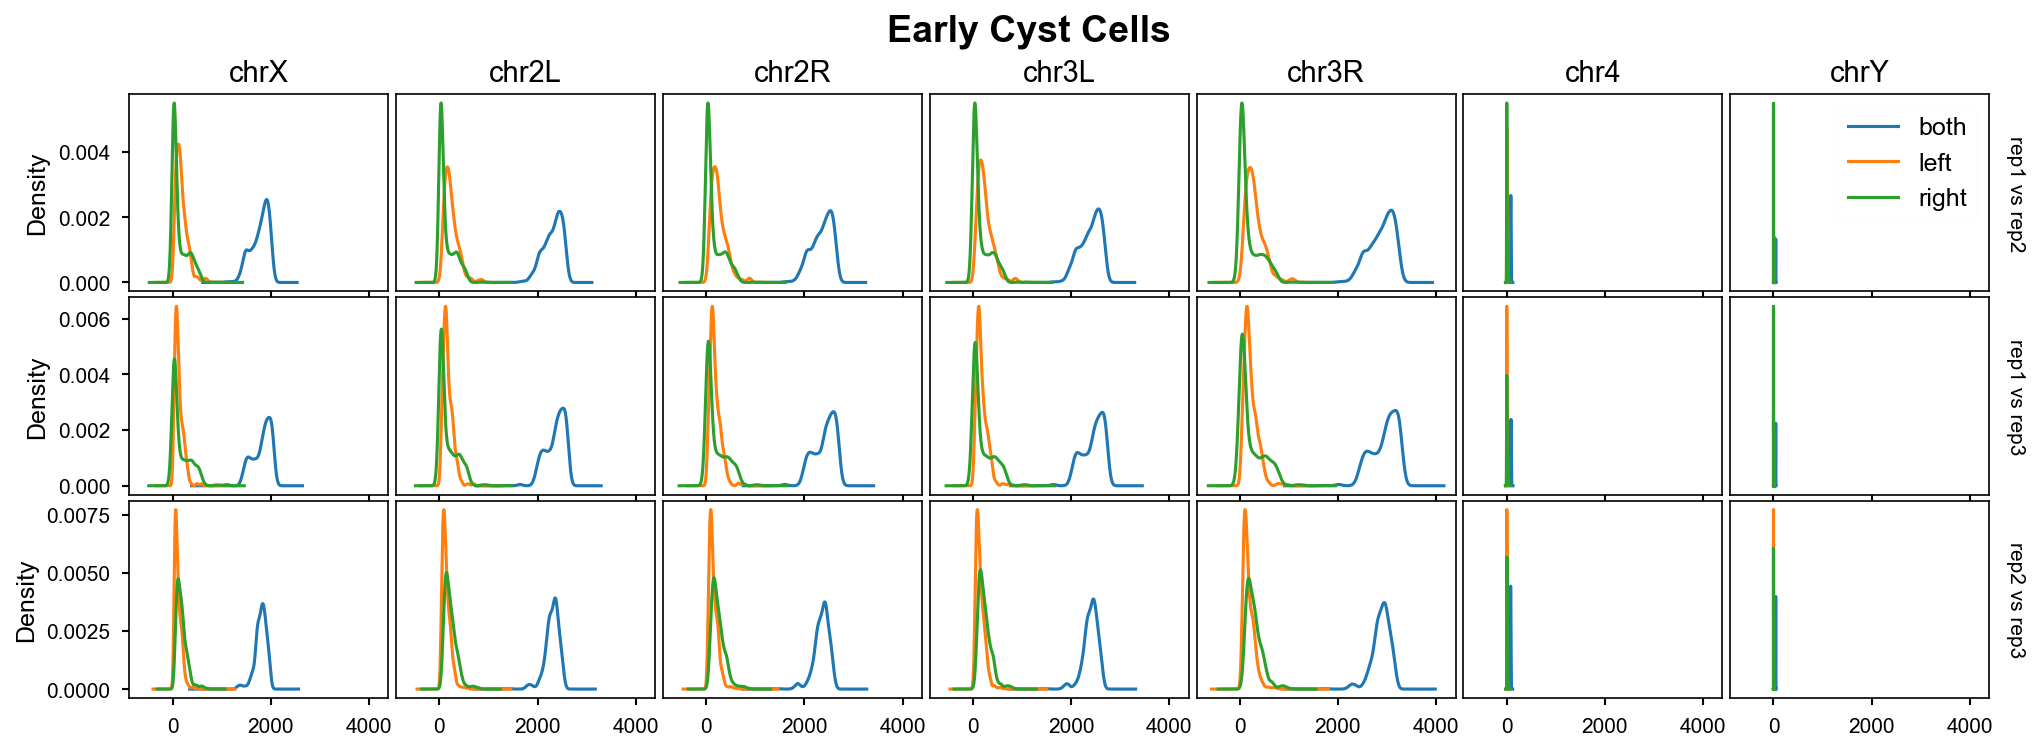

In [17]:
cluster = 'Early Cyst Cells'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

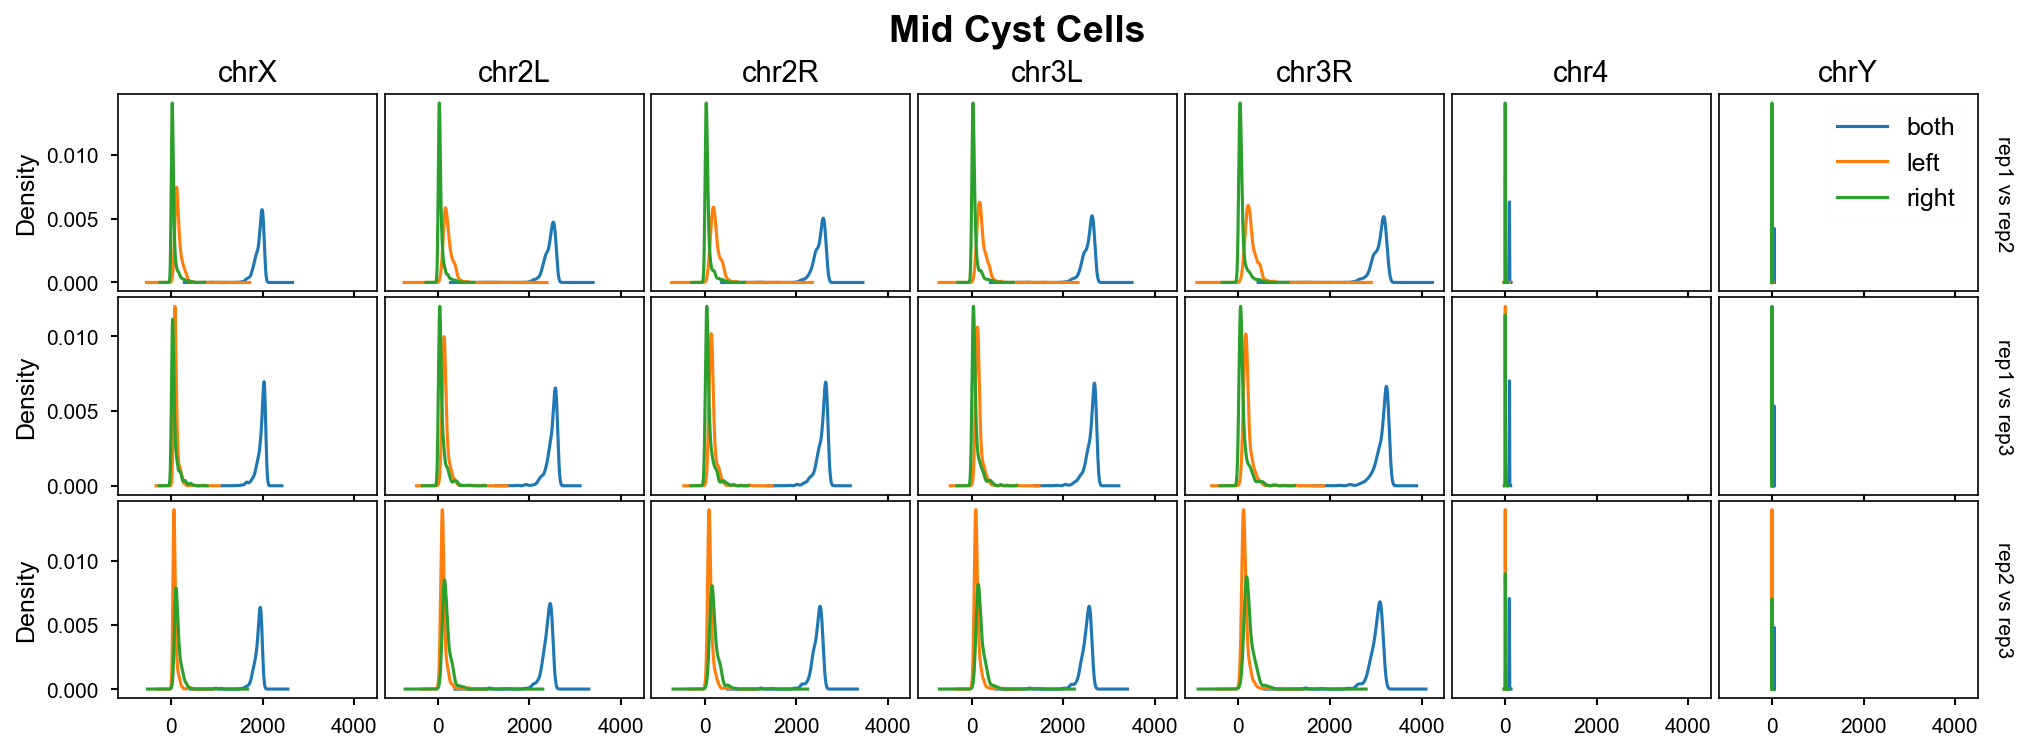

In [18]:
cluster = 'Mid Cyst Cells'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

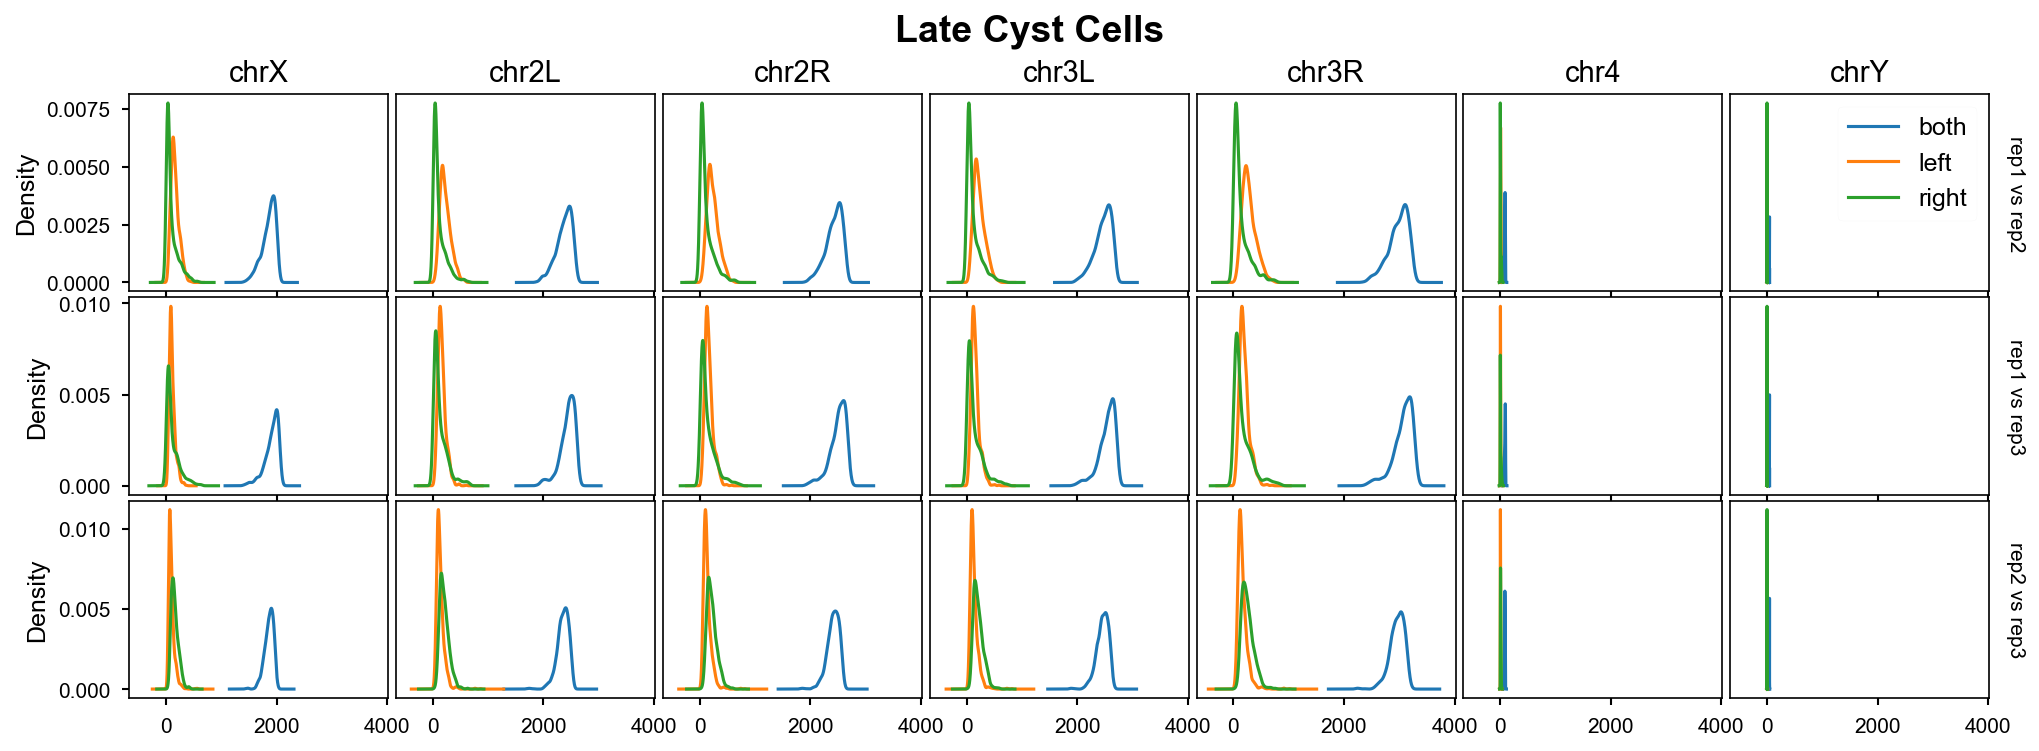

In [19]:
cluster = 'Late Cyst Cells'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

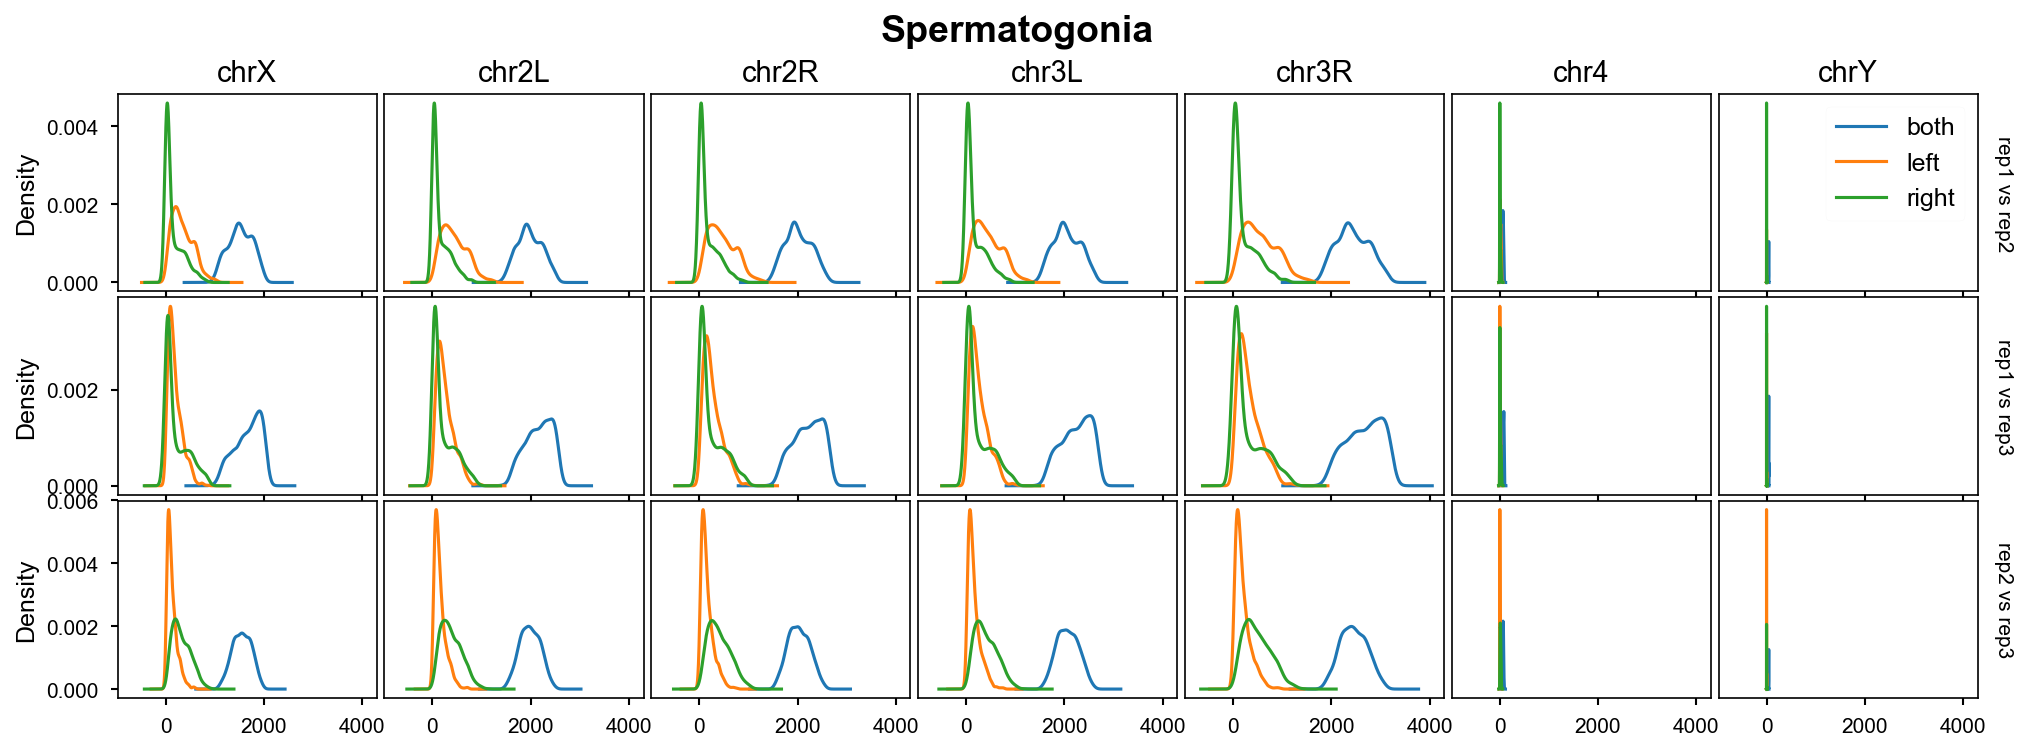

In [20]:
cluster = 'Spermatogonia'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

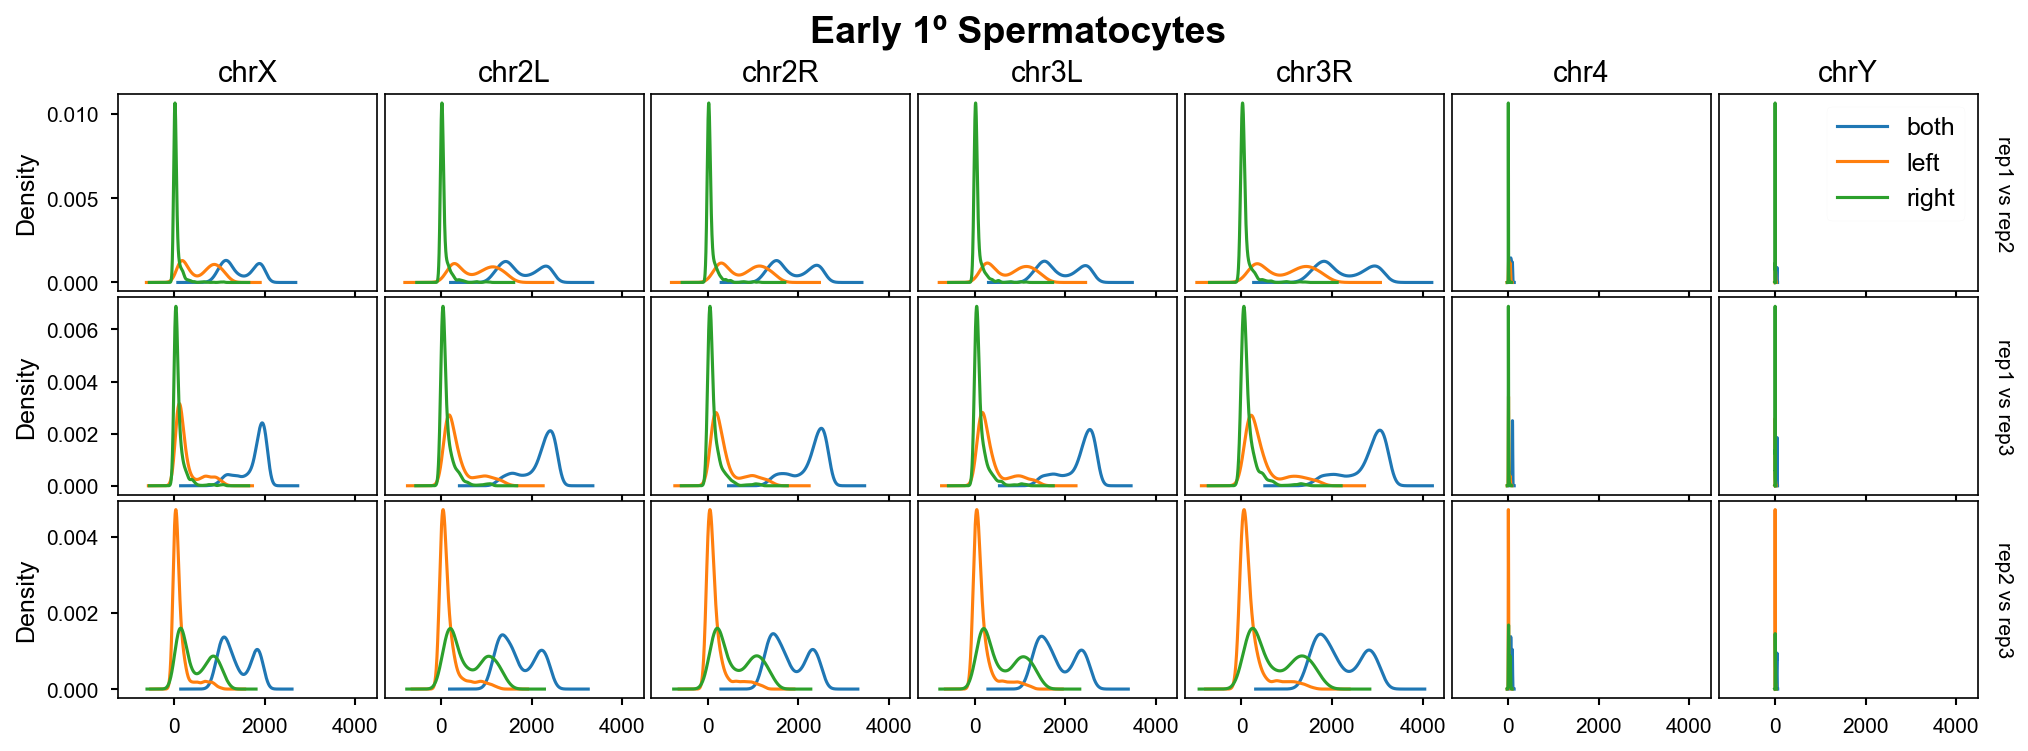

In [21]:
cluster = 'Early 1º Spermatocytes'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

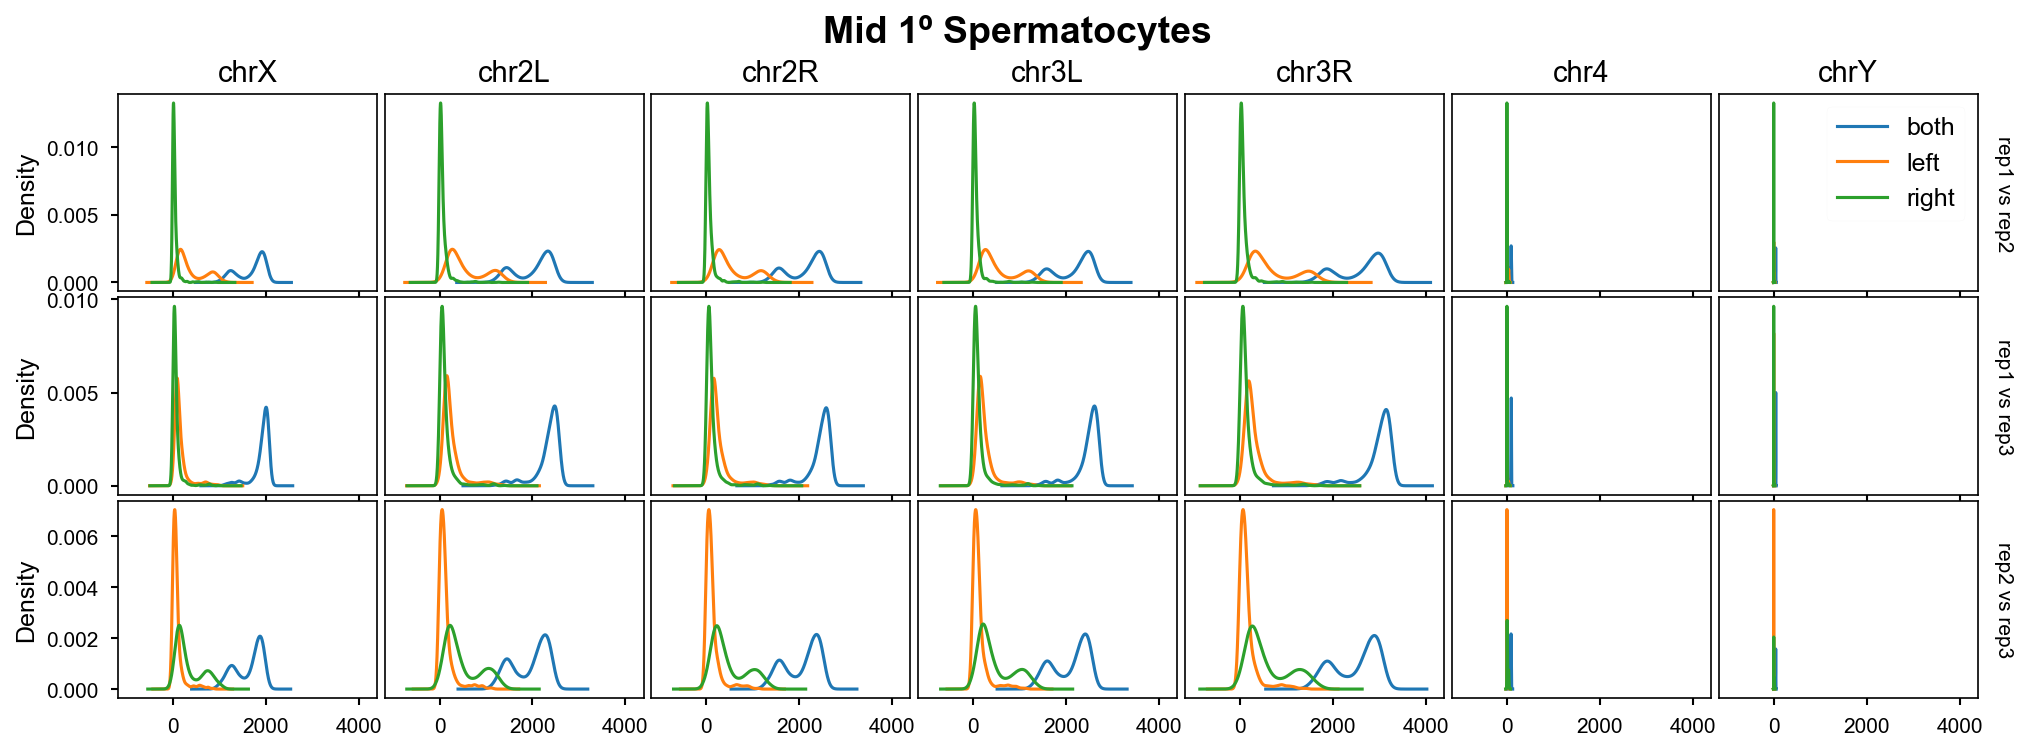

In [22]:
cluster = 'Mid 1º Spermatocytes'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

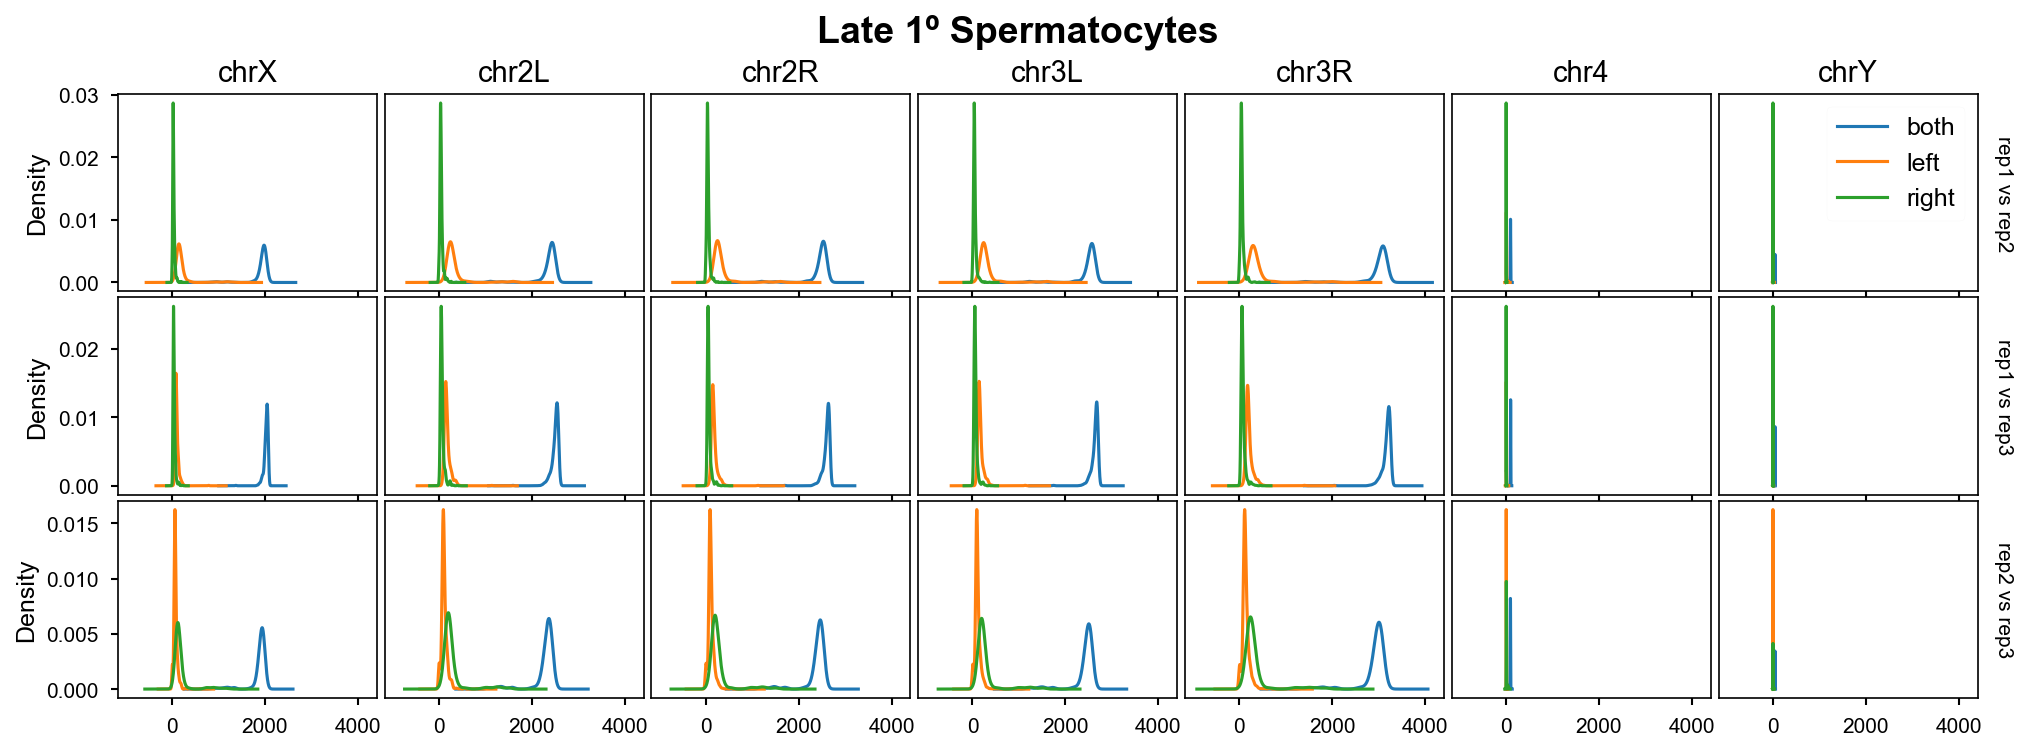

In [23]:
cluster = 'Late 1º Spermatocytes'

fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
sample2(cluster, 'rep1', 'rep3', axes[1, :])
sample2(cluster, 'rep2', 'rep3', axes[2, :])

for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
fig.suptitle(cluster);
axes[0, -1].legend();

## Now what??

So far I have seen that missingness is a major problem if we are wanting to compare across clusters. I am not too worried about the clustering and cell type assignment; Seurat is designed for scRNA-Seq and uses specific techniques to help with this. I am worried about comparing X:A across clusters and deciding on the best way to do this. I talked with Cameron (local stats person) and he thinks it would be best to calculate some sort of deviation from the autosomes. Then the statistic would be internal to cluster.

Essentially I need to come up with some metric and compare each autosomal arm to the autosomal median and get the deviation. Then I would compare the X to the autosomal median and get the deviation. Then I would calculate a statistic based on these deviations. The 4th is a little harder because it has so few genes. 


